# Extract frames

In [103]:
!ffmpeg -i IMG_1608.mov -vf "fps=29.97" -start_number 1000 -q:v 1 sample/%04d.png

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

# Train personal token (DreamBooth)

In [6]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Successfully uninstalled torch-2.0.1
Note: you may need to restart the kernel to use updated packages.
Found existing installation: torchvision 0.15.2
Uninstalling torchvision-0.15.2:
  Successfully uninstalled torchvision-0.15.2
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 468.4 kB/s eta 0:00:00:0100:10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 4.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import os
import torch
from natsort import natsorted
from glob import glob

In [2]:
cur_dir = os.getcwd()

In [3]:
# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.
concepts_list = [
    {
        "instance_prompt":      "lolli_poli",
        "class_prompt":         "portrait photo of a woman",
        "instance_data_dir":    os.path.join(cur_dir, "data/lolli_poli"),
        "class_data_dir":       os.path.join(cur_dir, "data/photosofwomen")
    },
#     {
#         "instance_prompt":      "photo of ukj person",
#         "class_prompt":         "photo of a person",
#         "instance_data_dir":    "/content/data/ukj",
#         "class_data_dir":       "/content/data/person"
#     }
]

# `class_data_dir` contains regularization images
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [ ]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = os.path.join(cur_dir, "stable_diffusion_weights/lolli_poli") #@param {type:"string"}

In [ ]:
!mkdir -p $OUTPUT_DIR

In [ ]:
!python3 train_dreambooth.py   \
--pretrained_model_name_or_path=MODEL_NAME   \
--pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse"   \
--output_dir=OUTPUT_DIR   \
--revision="fp16"   \
--with_prior_preservation  \
--prior_loss_weight=1.0   \
--seed=1337   \
--resolution=512   \
--train_batch_size=1   \
--train_text_encoder   \
--mixed_precision="fp16"   \
--use_8bit_adam   \
--gradient_accumulation_steps=1   \
--learning_rate=1e-6   \
--lr_scheduler="constant"   \
--lr_warmup_steps=64   \
--num_class_images=90   \
--sample_batch_size=1   \
--max_train_steps=640   \
--save_interval=700   \
--concepts_list="concepts_list.json"   \
--gradient_checkpointing   \
--class_prompt=concepts_list['class_prompt']  \
--not_cache_latents

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

In [6]:
WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
WEIGHTS_DIR

'/home/HDD6TB/pdemochkina/cows/HSE/StableDiffusion/HSE_project/stable_diffusion_weights/lolli_poli/640'

In [ ]:
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
# !python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
# print(f"[*] Converted ckpt saved at {ckpt_path}")

In [ ]:
!python convert_diffusers_to_original_stable_diffusion.py --model_path /home/HDD6TB/pdemochkina/cows/HSE/StableDiffusion/HSE_project/stable_diffusion_weights/lolli_poli/640  --checkpoint_path /home/HDD6TB/pdemochkina/cows/HSE/StableDiffusion/HSE_project/stable_diffusion_weights/lolli_poli/640/model.ckpt --half

In [4]:
OUTPUT_DIR = '/home/HDD6TB/pdemochkina/cows/HSE/StableDiffusion/HSE_project/stable_diffusion_weights/lolli_poli_2/640/'

# ControlNet

In [4]:
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np

In [5]:
from diffusers import ControlNetModel

In [6]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [7]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

In [8]:
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

# Img2Img

In [9]:
import os
from tqdm import tqdm
from diffusers import UniPCMultistepScheduler
from lalala import StableDiffusionControlNetInpaintImg2ImgPipeline
from PIL import Image, ImageSequence, ImageDraw

In [10]:
img2img_pipe = StableDiffusionControlNetInpaintImg2ImgPipeline.from_pretrained("parlance/dreamlike-diffusion-1.0-inpainting", 
                                                                               custom_pipeline="checkpoint_merger.py",
                                                                               torch_dtype=torch.float16).to("cuda")
# img2img_pipe.scheduler = UniPCMultistepScheduler.from_config(img2img_pipe.scheduler.config)
img2img_pipe.enable_xformers_memory_efficient_attention()

safety_checker/model.safetensors not found


In [11]:
merged_pipe = img2img_pipe.merge(["parlance/dreamlike-diffusion-1.0-inpainting",
                                  "stable_diffusion_weights/lolli_poli/640/", 
                                  "runwayml/stable-diffusion-v1-5"],
                                 controlnet=controlnet, torch_dtype=torch.float16,
                                 interp = 'add_diff', alpha = 0.1, force = True)

Received list ['parlance/dreamlike-diffusion-1.0-inpainting', 'stable_diffusion_weights/lolli_poli/640/', 'runwayml/stable-diffusion-v1-5']
Combining with alpha=0.05, interpolation mode=add_diff
Received the right number of checkpoints
Compatible model_index.json files found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cached Folder /home/HDD6TB/pdemochkina/.cache/huggingface/hub/models--parlance--dreamlike-diffusion-1.0-inpainting/snapshots/04432f6e7b46624e3217ef836844ae94f9a3b6e2
Cached Folder stable_diffusion_weights/lolli_poli/640/


Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Cached Folder /home/HDD6TB/pdemochkina/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/aa9ba505e1973ae5cd05f5aedd345178f52f8e6a


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu`

MERGING vae
MERGING text_encoder
Skipping tokenizer: not present in 2nd or 3d model
MERGING unet
Skipping controlnet do to an unexpected error: [Errno 2] No such file or directory: 'stable_diffusion_weights/lolli_poli/640/controlnet'
Skipping scheduler: not present in 2nd or 3d model
Skipping safety_checker do to an unexpected error: [Errno 2] No such file or directory: 'stable_diffusion_weights/lolli_poli/640/safety_checker'
Skipping feature_extractor: not present in 2nd or 3d model
Skipping requires_safety_checker do to an unexpected error: 'StableDiffusionControlNetInpaintImg2ImgPipeline' object has no attribute 'requires_safety_checker'


In [12]:
merged_pipe.safety_checker = lambda images, clip_input: (images, False)

In [13]:
merged_pipe.to("cuda:1")

StableDiffusionControlNetInpaintImg2ImgPipeline {
  "_class_name": "StableDiffusionControlNetInpaintImg2ImgPipeline",
  "_diffusers_version": "0.15.0",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "__main__",
    "function"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [31]:
# prompt = '(lolli_poli:1.4)++ vector midjourney style greg rutkowski digital art'
# prompt = '(lolli_poli:1.4)++ (pen drawing)++ black and white, midjourney style digital art'
# prompt = 'ultra detailed statue of (lolli_poli:1.4)++ midjourney style hyperrealism, white marble michelangelo, \
#         high resolution details, intricate design, and a marble hall background'
# prompt = 'avatar of (lolli_poli:1.4)++ astronaut, midjourney style hyperrealism, dark galaxy space background'
# prompt = '(lolli_poli:1.4)++ as a wizard in a hat and cloak, Harry Potter, Hogwards background,  Wizarding world of harry potter by Jim Kay'
# prompt = '(lolli_poli:1.4)++ in style (starry night by Van Gogh)++, dark blue sky and white yellow strokes swirls stars, \
# #           midjourney style, 4k, painting intricate details'
# prompt = 'avatar of (lolli_poli:1.4)++ pokemon, midjourney style hyperrealism, city background'
prompt = 'magical (lolli_poli:1.4) midjourney style hyperrealism Cyberpunk+, city background\
#           greg rutkowski, digital art rainbow background happy, peace sign'
negative_prompt = "out of frame, duplicate, watermark, signature, text, ugly, blurry, deformed"

In [15]:
import matplotlib.pyplot as plt

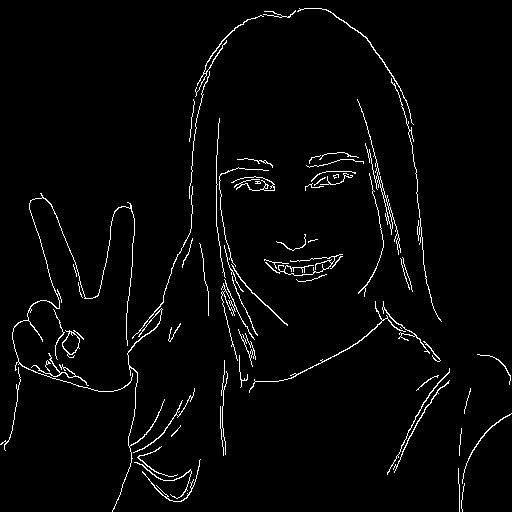

In [21]:
image = load_image('/home/HDD6TB/pdemochkina/cows/HSE/StableDiffusion/HSE_project/sample/1050.png')
image = image.resize((512, 512))
image = np.array(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

low_threshold = 80
high_threshold = 200

canny_image = cv2.Canny(gray, low_threshold, high_threshold, L2gradient=True)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)
canny_image

  0%|          | 0/30 [00:00<?, ?it/s]

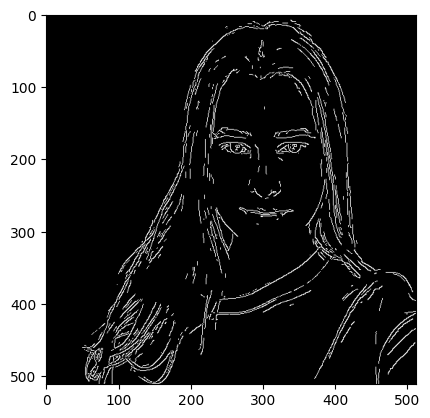

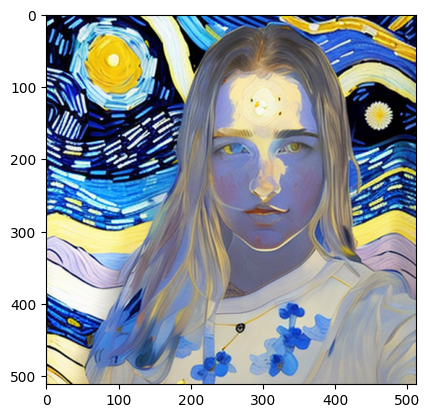

  0%|          | 0/25 [00:00<?, ?it/s]

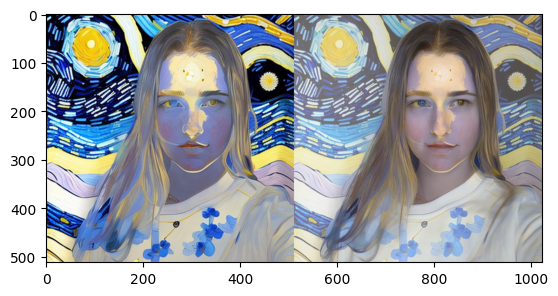

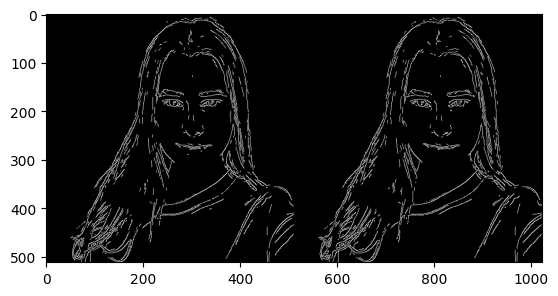

  0%|          | 0/25 [00:00<?, ?it/s]

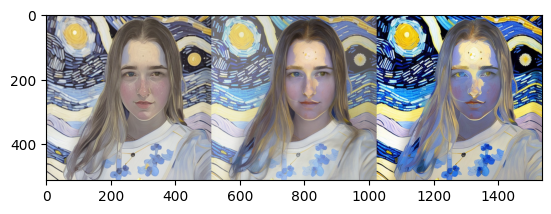

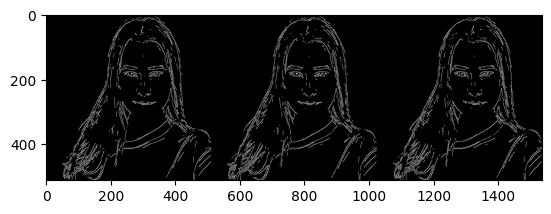

In [33]:
data_dir = '/home/HDD6TB/pdemochkina/cows/HSE/StableDiffusion/HSE_project/sample/'
save_dir = '/home/HDD6TB/pdemochkina/cows/HSE/StableDiffusion/HSE_project/result/'

g_cuda = torch.Generator(device='cuda')
seed = 803465 # 803465
g_cuda.manual_seed(seed)

for i, filename in enumerate(sorted(os.listdir(data_dir))):
    img_path = os.path.join(data_dir, filename)
    image = load_image(img_path)
    image = image.resize((512, 512))
    image = np.array(image)

    low_threshold = 120
    high_threshold = 150

    canny_image = cv2.Canny(image, low_threshold, high_threshold)
    canny_image = canny_image[:, :, None]
    canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
    canny_image = Image.fromarray(canny_image)
    width, height = canny_image.size
    
    if i == 0:
        latent_mask = Image.new("RGB", (width, height), "white")
    
        result = merged_pipe(prompt,
                      negative_prompt=negative_prompt,
                      num_inference_steps=30,
                      generator=g_cuda,
                      image=image,
                      controlnet_conditioning_image=canny_image,
                      controlnet_conditioning_scale=1.0,
                      strength=1.0,
                      mask_image = latent_mask,
                      guidance_scale = 20
                     ).images[0].crop((0,0,width,height))
    
        frame_1 = result.copy()
        canny_image_1 = canny_image.copy()
        
#         plt.imshow(image)
#         plt.show()
        plt.imshow(canny_image)
        plt.show()
#         plt.imshow(latent_mask)
#         plt.show()
    
    elif i == 1:
        total_width = width*2
        images = Image.new('RGB', (total_width, height))
        cannys = Image.new('RGB', (total_width, height))
        
        x_offset = 0
        for im in [frame_1, 
#                    Image.fromarray(image)
                   Image.fromarray(np.array(image*0.5 + np.array(frame_1)*0.5).astype(np.uint8))
#                    frame_1
                  ]:  #Image.fromarray(image)]:
            images.paste(im, (x_offset,0))
            x_offset += im.size[0]
            
        plt.imshow(frame_1)
        plt.show()
            
        x_offset = 0
        for im in [canny_image_1, canny_image]:
            cannys.paste(im, (x_offset,0))
            x_offset += im.size[0]
            
        latent_mask = Image.new("RGB", (width*2, height), "black")
        latent_draw = ImageDraw.Draw(latent_mask)
        latent_draw.rectangle((width,0,width*2,height), fill="white")
    
        result = merged_pipe(prompt,
                      negative_prompt=negative_prompt,
                      num_inference_steps=50,
                      generator=g_cuda,
                      image=images,
                      controlnet_conditioning_image=cannys,
                      controlnet_conditioning_scale=0.9,
                      strength=0.5,
                      mask_image = latent_mask,
                      guidance_scale = 30
                     ).images[0].crop((width,0,width*2,height))
        
        canny_image_2 = canny_image.copy()
        frame_2 = result.copy()
        hist_frame = frame_1
        
        plt.imshow(images)
        plt.show()
        plt.imshow(cannys)
        plt.show()
#         plt.imshow(latent_mask)
#         plt.show()
        
    else:
        total_width = width*3
        images = Image.new('RGB', (total_width, height))
        cannys = Image.new('RGB', (total_width, height))
        
        x_offset = 0
        for im in [frame_2, 
#                    Image.fromarray(image),
#                    frame_1,
                   Image.fromarray(np.array(image*0.5 + np.array(frame_1)*0.5).astype(np.uint8)), 
                   frame_1]:  #Image.fromarray(image)
            images.paste(im, (x_offset,0))
            x_offset += im.size[0]
            
        x_offset = 0
        for im in [canny_image_2, canny_image, canny_image_1]:
            cannys.paste(im, (x_offset,0))
            x_offset += im.size[0]
            
        latent_mask = Image.new("RGB", (width*3, height), "black")
        latent_draw = ImageDraw.Draw(latent_mask)
        latent_draw.rectangle((width,0,width*2,height), fill="white")
        
        result = merged_pipe(prompt,
                      negative_prompt=negative_prompt,
                      num_inference_steps=50,
                      generator=g_cuda,
                      image=images,
                      controlnet_conditioning_image=cannys,
                      controlnet_conditioning_scale=0.9,
                      strength=0.5,
                      mask_image = latent_mask,
                      guidance_scale = 30
                     ).images[0].crop((width,0,width*2,height))
        
        canny_image_2 = canny_image.copy()
        hist_frame = frame_2
        frame_2 = result.copy()
        
        plt.imshow(images)
        plt.show()
        plt.imshow(cannys)
        plt.show()
#         plt.imshow(latent_mask)
#         plt.show()
        
    result.save(os.path.join(save_dir, filename))

# Restore faces

In [ ]:
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

In [ ]:
!python inference_gfpgan.py -i inputs/upload -o results -v 1.3 -s 2 --bg_upsampler realesrgan

# Final video

In [2]:
!rm 'restored_result/restored_imgs/1000.png'   # remove first frame

In [4]:
!ffmpeg -framerate 30 -pattern_type glob -i 'restored_result/restored_imgs/*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e